# taking mesh snapshots for figures

In [1]:
%matplotlib inline
from lib.my_initialization import *
# from lib.controller.one_step_forward_euler import *
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


In [2]:
#define Lamé parameters
mu = 1.; lam = 10.; 
#define coefficient for Rayleigh damping
gamma = 0.0#1.#1.;

#define adaptive time stepping absolute tolerances
salience = 2#128#32
learning_rate = np.log(salience) #np.log(16) #np.log(2)
lasso_fraction = 0.5
v_scale = 3.
mass_density=1.

stepsize_init = 0.001#0.00005#0.0001
atol_x = 0.0001#0.001#1e-7; 
atol_v = 0.0001#0.001#1e-7; 
btol_x = 0.0001#0.001#1e-10; 
btol_v = 0.0001#0.001#1e-10; 

#path to mesh
input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
#where to save results
data_folder =  os.path.join(nb_dir,'../data/mov_csv')
data_fn = f"avi_ns_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
save_folder_vid = '../vid/tmp'
folder_vid = '../vid'
# data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npz')
data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npy')

os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
input_file_name = os.path.join(nb_dir,input_file_name)
tme = 0.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
N_elements = element_array_index.shape[0]
N_vertices = node_array_position.shape[0]
print(list(dict_values_system.keys()))

#header to start of video
# TEXT = '''TEXT=$'Synchronous Variational Integrator\nDamped Neohookean Model\n(inward squish)''''
TEXT = f"""
TEXT=$'an inward squish with neural time steps
        Asynchronous Variational Integrator 
        Dormand–Prince Method
        
        Undamped Neohookean Model
        mu {mu}  lambda {lam} gamma {gamma}
        
        Spherical Mesh
        Num. Vertices {N_vertices}
        Num. Elements {N_elements}
'"""

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


In [3]:
#initialize system
tauK = element_array_time
tau = node_array_time

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
# comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

#initialize stepsizes of simulation
element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
momentum = node_array_momentum.copy()
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]


# #perturb momentum in the x direction and let it run overnight with a small timestep  
velocities[:,0] = -v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
energy_lst = []
tme_lst    = []
stepsize_mean_lst   = []
stepsize_std_lst    = []
stepsize_median_lst = []
stepsize_count_lst = []
frac_lg = lambda i: 2**i  ##np.exp((i+.5)*learning_rate/10)
# learning_bins = np.array([stepsize_init*frac_lb(i) for i in np.arange(-30,30)])

#this looks nice. 30 bins
learning_bins = np.array([0.00480198, 0.00480886, 0.00481574, 0.00482262, 0.00482951,
        0.00483639, 0.00484327, 0.00485015, 0.00485703, 0.00486391,
        0.0048708 , 0.00487768, 0.00488456, 0.00489144, 0.00489832,
        0.0049052 , 0.00491209, 0.00491897, 0.00492585, 0.00493273,
        0.00493961, 0.00494649, 0.00495338, 0.00496026, 0.00496714,
        0.00497402, 0.0049809 , 0.00498778, 0.00499467, 0.00500155,
        0.00500843])

# #let's try 100 bins
# learning_bins = np.array([0.00477609, 0.00477838, 0.00478067, 0.00478296, 0.00478526,
#         0.00478755, 0.00478984, 0.00479214, 0.00479443, 0.00479672,
#         0.00479902, 0.00480131, 0.0048036 , 0.0048059 , 0.00480819,
#         0.00481048, 0.00481277, 0.00481507, 0.00481736, 0.00481965,
#         0.00482195, 0.00482424, 0.00482653, 0.00482883, 0.00483112,
#         0.00483341, 0.00483571, 0.004838  , 0.00484029, 0.00484258,
#         0.00484488, 0.00484717, 0.00484946, 0.00485176, 0.00485405,
#         0.00485634, 0.00485864, 0.00486093, 0.00486322, 0.00486552,
#         0.00486781, 0.0048701 , 0.0048724 , 0.00487469, 0.00487698,
#         0.00487927, 0.00488157, 0.00488386, 0.00488615, 0.00488845,
#         0.00489074, 0.00489303, 0.00489533, 0.00489762, 0.00489991,
#         0.00490221, 0.0049045 , 0.00490679, 0.00490908, 0.00491138,
#         0.00491367, 0.00491596, 0.00491826, 0.00492055, 0.00492284,
#         0.00492514, 0.00492743, 0.00492972, 0.00493202, 0.00493431,
#         0.0049366 , 0.0049389 , 0.00494119, 0.00494348, 0.00494577,
#         0.00494807, 0.00495036, 0.00495265, 0.00495495, 0.00495724,
#         0.00495953, 0.00496183, 0.00496412, 0.00496641, 0.00496871,
#         0.004971  , 0.00497329, 0.00497558, 0.00497788, 0.00498017,
#         0.00498246, 0.00498476, 0.00498705, 0.00498934, 0.00499164,
#         0.00499393, 0.00499622, 0.00499852, 0.00500081, 0.0050031 ,
#         0.00500539])

# learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
print(f"learning_bins are {learning_bins}")

learning_bins are [0.00480198 0.00480886 0.00481574 0.00482262 0.00482951 0.00483639
 0.00484327 0.00485015 0.00485703 0.00486391 0.0048708  0.00487768
 0.00488456 0.00489144 0.00489832 0.0049052  0.00491209 0.00491897
 0.00492585 0.00493273 0.00493961 0.00494649 0.00495338 0.00496026
 0.00496714 0.00497402 0.0049809  0.00498778 0.00499467 0.00500155
 0.00500843]


In [4]:
#choose your fighter
# integrate_system_explicit_synchronous = get_integrate_system_explicit_synchronous(mu,lam,gamma)
# integrate_system_implicit_synchronous = get_integrate_system_implicit_synchronous(mu,lam,gamma,num_iter=30)
# integrate_system_dormand_prince_synchronous = get_integrate_system_dormand_prince_synchronous(mu,lam,gamma)
integrate_system_dormand_prince_asynchronous = get_integrate_system_dormand_prince_asynchronous(mu,lam,gamma,atol_x, atol_v, btol_x, btol_v,learning_rate, lasso_fraction)
#(optional) #view the mesh
# plot_mesh(vertices, input_file_name=input_file_name, darkmode=True)

In [5]:
#prepare for video
frameno = 1
time_between_observations = 0.01
time_of_next_observation = tme + time_between_observations

# #empty the temporary folder, vid/tmp
# os.chdir(nb_dir)
# os.chdir(folder_vid)
# !rm -r tmp
# os.mkdir('tmp')

# #write header to file
# # print(TEXT)
# # Dormand–Prince Method
# # Explicit Newmark Method
# # Implicit Midpoint Rule
# with open("mov/text.txt", "w") as file:
#     file.write(TEXT)
#     file.close()

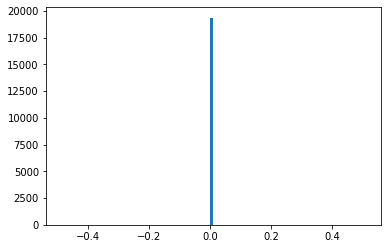

In [6]:
img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time=0.00')

# img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={time_of_next_observation:.2f}')
Img = Image.fromarray(img)
save_fn_img = nb_dir + "/../fig/s_time_0.png"
Img.save(save_fn_img)
# Img
plt.hist(element_array_stepsize, bins=100)
plt.show()

In [7]:
#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)
time_end_recording = 0.05#.2
while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
    #     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    integrate_system_dormand_prince_asynchronous(
        tf,
        element_array_time,
        element_array_stepsize,
        node_array_time,
        element_array_index,
        vertices,
        velocities,
        node_array_mass,
        element_array_inverse_equilibrium_position,
        element_array_mass
    )
    
    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
    try:
        pass
#         img = get_img_of_system(vertices, input_file_name, darkmode = True, text=f'time={tf:.2f}')
    except:
        pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
#     Img.save(save_fn_img)
    
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

/Users/timothytyree/Documents/GitHub/avi/nb/lib/controller/integrate_forward_dormand_prince_asynchronous.py:94: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  energy_prev = comp_element_energy ( mass_of_K, v, W, Bm, Ds, mu, lam)
/Users/timothytyree/Documents/GitHub/avi/nb/lib/controller/integrate_forward_dormand_prince_asynchronous.py:97: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  max_err, mav_err, x_out,v_out = one_step_explicit_dormand_prince_method(h,x,v,K_masses,K_tau,tau_of_K,Bm)


0.32 0.0 0.32


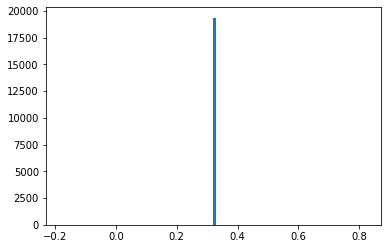

In [8]:
img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={time_of_next_observation:.2f}')
Img = Image.fromarray(img)
save_fn_img = nb_dir + "/../fig/s_time_0.05.png"
Img.save(save_fn_img)
# Img
plt.hist(element_array_stepsize, bins=100)
plt.show()

In [9]:
#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)
time_end_recording = 0.1#.2
while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
    #     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    integrate_system_dormand_prince_asynchronous(
        tf,
        element_array_time,
        element_array_stepsize,
        node_array_time,
        element_array_index,
        vertices,
        velocities,
        node_array_mass,
        element_array_inverse_equilibrium_position,
        element_array_mass
    )
    
    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
    try:
        pass
#         img = get_img_of_system(vertices, input_file_name, darkmode = True, text=f'time={tf:.2f}')
    except:
        pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
#     Img.save(save_fn_img)
    
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

10.24 0.0 10.24


In [10]:
img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={time_of_next_observation:.2f}')
Img = Image.fromarray(img)
save_fn_img = nb_dir + "/../fig/s_time_0.1.png"
Img.save(save_fn_img)
# Img


In [11]:
element_array_stepsize

array([10.24, 10.24, 10.24, ..., 10.24, 10.24, 10.24])

(array([    0.,     0.,     0.,     0.,     0., 19375.,     0.,     0.,
            0.,     0.]),
 array([ 9.74,  9.84,  9.94, 10.04, 10.14, 10.24, 10.34, 10.44, 10.54,
        10.64, 10.74]),
 <BarContainer object of 10 artists>)

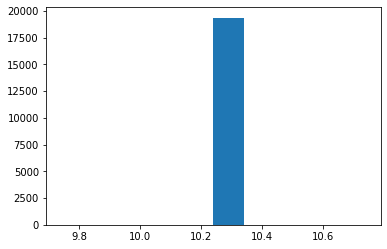

In [12]:
plt.hist(element_array_stepsize.T)#, bins=100)
# plt.show()
# element_array_stepsize

In [13]:
#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)
time_end_recording = 0.2
while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
    #     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    integrate_system_dormand_prince_asynchronous(
        tf,
        element_array_time,
        element_array_stepsize,
        node_array_time,
        element_array_index,
        vertices,
        velocities,
        node_array_mass,
        element_array_inverse_equilibrium_position,
        element_array_mass
    )
    
    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
    try:
        pass
#         img = get_img_of_system(vertices, input_file_name, darkmode = True, text=f'time={tf:.2f}')
    except:
        pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
#     Img.save(save_fn_img)
    
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

5242.88 0.0 5242.88


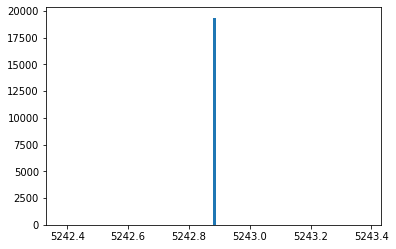

In [14]:
img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={time_of_next_observation:.2f}')
Img = Image.fromarray(img)
save_fn_img = nb_dir + "/../fig/s_time_0.2.png"
Img.save(save_fn_img)
# Img
plt.hist(element_array_stepsize, bins=100)
plt.show()

In [15]:
#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)
time_end_recording = 0.3
while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
    #     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    integrate_system_dormand_prince_asynchronous(
        tf,
        element_array_time,
        element_array_stepsize,
        node_array_time,
        element_array_index,
        vertices,
        velocities,
        node_array_mass,
        element_array_inverse_equilibrium_position,
        element_array_mass
    )
    
    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
    try:
        pass
#         img = get_img_of_system(vertices, input_file_name, darkmode = True, text=f'time={tf:.2f}')
    except:
        pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
#     Img.save(save_fn_img)
    
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

5368709.12 0.0 5368709.12


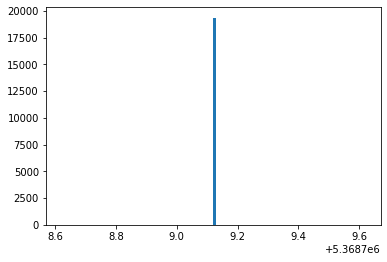

In [16]:
img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={time_of_next_observation:.2f}')
Img = Image.fromarray(img)
save_fn_img = nb_dir + "/../fig/s_time_0.3.png"
Img.save(save_fn_img)
# Img
plt.hist(element_array_stepsize, bins=100)
plt.show()

In [17]:
#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)
time_end_recording = 0.4
while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
    #     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    integrate_system_dormand_prince_asynchronous(
        tf,
        element_array_time,
        element_array_stepsize,
        node_array_time,
        element_array_index,
        vertices,
        velocities,
        node_array_mass,
        element_array_inverse_equilibrium_position,
        element_array_mass
    )
    
    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
    try:
        pass
#         img = get_img_of_system(vertices, input_file_name, darkmode = True, text=f'time={tf:.2f}')
    except:
        pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
#     Img.save(save_fn_img)
    
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

5497558138.88 0.0 5497558138.88


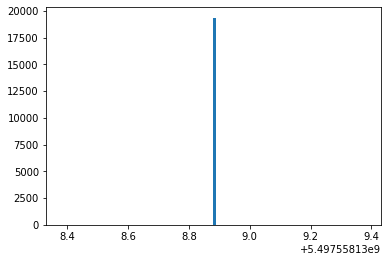

In [18]:
img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={time_of_next_observation:.2f}')
Img = Image.fromarray(img)
save_fn_img = nb_dir + "/../fig/s_time_0.4.png"
Img.save(save_fn_img)
# Img
plt.hist(element_array_stepsize, bins=100)
plt.show()

In [19]:
#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)
time_end_recording = 0.5
while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
    #     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    integrate_system_dormand_prince_asynchronous(
        tf,
        element_array_time,
        element_array_stepsize,
        node_array_time,
        element_array_index,
        vertices,
        velocities,
        node_array_mass,
        element_array_inverse_equilibrium_position,
        element_array_mass
    )
    
    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
    try:
        pass
#         img = get_img_of_system(vertices, input_file_name, darkmode = True, text=f'time={tf:.2f}')
    except:
        pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
#     Img.save(save_fn_img)
    
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

5629499534213.12 0.0 5629499534213.12


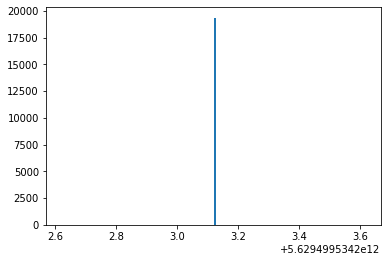

In [20]:
img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={time_of_next_observation:.2f}')
Img = Image.fromarray(img)
save_fn_img = nb_dir + "/../fig/s_time_0.5.png"
Img.save(save_fn_img)
# Img
plt.hist(element_array_stepsize, bins=100)
plt.show()

In [21]:
#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)
time_end_recording = 1.#
while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
    #     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    integrate_system_dormand_prince_asynchronous(
        tf,
        element_array_time,
        element_array_stepsize,
        node_array_time,
        element_array_index,
        vertices,
        velocities,
        node_array_mass,
        element_array_inverse_equilibrium_position,
        element_array_mass
    )
    
    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
    try:
        pass
#         img = get_img_of_system(vertices, input_file_name, darkmode = True, text=f'time={tf:.2f}')
    except:
        pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
#     Img.save(save_fn_img)
    
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

6.338253001141147e+27 0.0 6.338253001141147e+27


/usr/local/lib/python3.8/site-packages/numpy/lib/histograms.py:822: RuntimeWarning: divide by zero encountered in double_scalars
  norm = n_equal_bins / _unsigned_subtract(last_edge, first_edge)
/usr/local/lib/python3.8/site-packages/numpy/lib/histograms.py:850: RuntimeWarning: invalid value encountered in multiply
  f_indices = _unsigned_subtract(tmp_a, first_edge) * norm


IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 101

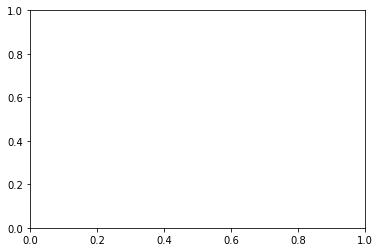

In [22]:
img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={time_of_next_observation:.2f}')
Img = Image.fromarray(img)
save_fn_img = nb_dir + "/../fig/s_time_1.png"
Img.save(save_fn_img)
# Img
plt.hist(element_array_stepsize, bins=100)
plt.show()

In [ ]:
#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)
time_end_recording = 2.#
while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
    #     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    integrate_system_dormand_prince_asynchronous(
        tf,
        element_array_time,
        element_array_stepsize,
        node_array_time,
        element_array_index,
        vertices,
        velocities,
        node_array_mass,
        element_array_inverse_equilibrium_position,
        element_array_mass
    )
    
    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
    try:
        pass
#         img = get_img_of_system(vertices, input_file_name, darkmode = True, text=f'time={tf:.2f}')
    except:
        pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
#     Img.save(save_fn_img)
    
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
beep(3)

In [ ]:
img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={time_of_next_observation:.2f}')
Img = Image.fromarray(img)
save_fn_img = nb_dir + "/../fig/s_time_2.png"
Img.save(save_fn_img)
# Img
plt.hist(element_array_stepsize, bins=100)
plt.show()